In [2]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pdb
from scipy.io import loadmat
from scipy import optimize
from math import pi, log2
from utils import *
import warnings
from DataFile import DataFile

In [3]:
mat_files = [m for m in os.listdir("data") if m.endswith('mat')]
session_list = pd.read_excel('data/CacheRetrieveSessionList.xlsx', index_col=0)
fps = 20
cmap = cm.get_cmap('viridis')

## Identifying place cells

In [5]:
plot = False
results = {}
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    spatial_mat = np.zeros(f.num_neurs)
    significants = np.zeros(f.num_neurs).astype(bool)
    for neur in np.arange(f.num_neurs):
        neur_spikes = f.spikes[:, neur]
        neur_fr = f.fr[:,neur]
        spatial_info = get_mutual_info(
            f.wedges[f.wedges != 17], neur_fr[f.wedges != 17]
            )
        shuffled_info = []
        shuffled_peak_fr = []
        for _ in range(110):
            shuffled_spikes = circular_shuffle(neur_spikes)
            shuffled_fr = get_fr(shuffled_spikes)
            shuffled_info.append(get_mutual_info(
                f.wedges[f.wedges != 17], shuffled_fr[f.wedges != 17]
                ))
            shuffled_peak_fr.append(shuffled_fr.max())
        shuffled_info = np.array(shuffled_info)
        high_mutual_info = np.sum(shuffled_info < spatial_info) > 0.99*shuffled_info.size
        spatial_mat[neur] = spatial_info/np.mean(shuffled_info)
        if high_mutual_info:
            significants[neur] = True
        # Plotting for debugging
        if plot:
            df = pd.DataFrame({
                "loc":f.wedges[f.wedges != 17],
                "spikerate":neur_fr[f.wedges != 17]
                })
            plt.figure(figsize=(10,5))
            sns.pointplot(x="loc", y="spikerate", data=df)
            if high_mutual_info:
                plt.title("Place Cell")
            else:
                plt.title("Not Place Cell")
            plt.show()
            print(spatial_info)
    results[mat_file] =  {"Matrix": spatial_mat, "Significants": significants}
with open("spatial-all.p", "wb") as f:
    pickle.dump(results, f)

ExtractedWithXY_Cleaned184713_09102019.mat
ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat


/home/chingf/Code/hf-data-analysis/utils.py:93: RuntimeWarning: invalid value encountered in double_scalars
  log_term = log2(ctxt_mean_fr/mean_fr)


ExtractedWithXY_Cleaned144233_09112019.mat


## Identifying specific episode cells visit-by-visit, centered by hop
Looking at a window around each cache. Specificity for a cache at a specific location

In [12]:
window = 60
results = {}
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    cache_idxs = np.zeros((f.cache_sites.size, f.num_neurs))
    results[mat_file] = np.zeros((f.cache_sites.size, f.num_neurs))
    cache_hops_frames, noncache_hops_frames, noncache_hops_wedges = \
        f.get_hopcentered_frames(window)
    for idx in range(f.cache_sites.size):
        cache_site = f.cache_sites[idx]
        cache_frames = cache_hops_frames[idx]
        noncache_frames = [
            arr for idx, arr in enumerate(noncache_hops_frames)\
            if noncache_hops_wedges[idx] == cache_site
            ]
        noncache_frames = np.concatenate(noncache_frames)
        context_frames = np.concatenate([
            cache_frames, noncache_frames
            ])
        contexts = np.concatenate([
            np.ones(cache_frames.size),
            np.zeros(noncache_frames.size)
            ])
        cache_info = get_mutual_info_mat(contexts, f.fr[context_frames,:])
        significant = np.zeros(f.num_neurs)
        shuffled_infos = np.zeros(f.num_neurs)
        for _ in range(110):
            shuff_spikes = f.spikes[context_frames,:]
            shuff_spikes = circular_shuffle(shuff_spikes)
            shuff_fr = get_fr(shuff_spikes)
            shuff_cache_frames, shuff_noncache_frames = \
                circular_shuffle_two_nparrays(cache_frames, noncache_frames)
            shuff_context_frames = np.concatenate([
                shuff_cache_frames, shuff_noncache_frames
                ])
            shuff_cache_info = get_mutual_info_mat(
                contexts, f.fr[shuff_context_frames,:]
                )
            shuffled_infos += shuff_cache_info
            significant += (cache_info > shuff_cache_info)
        significant = significant > 0.99*110
        shuffled_infos = shuffled_infos/110
        results[mat_file][idx, significant] = \
            cache_info[significant]/shuffled_infos[significant]
        if np.sum(np.isinf(results[mat_file][idx, significant])):
            import pdb; pdb.set_trace()
with open("mi-hopvis-circvisshuff-%d.p"%window, "wb") as f:
    pickle.dump(results, f)

ExtractedWithXY_Cleaned184713_09102019.mat
ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


ExtractedWithXY_Cleaned184713_09102019.mat
[ 6  7  9 11 14 21 25 36 37 38]
Min: 1.00
Max: 1.00


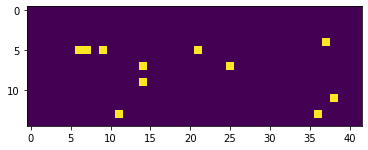


ExtractedWithXY_Cleaned184430_09102019.mat
[ 4  6  7  8  9 10 12 18 20 24 25 29 31 32 40 46 48]
Min: 1.00
Max: 1.00


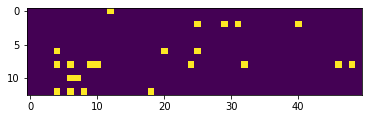


ExtractedWithXY_Cleaned184526_09102019.mat
[ 3  4  5  7  8 13 15 17 21 23 25 29 35 38 39 40 42 43]
Min: 1.00
Max: 1.00


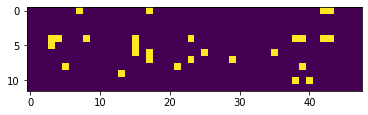


ExtractedWithXY_Cleaned184946_09102019.mat
[ 1  3  5  6 12 15 17 18 27 28 29 30 31 33 44 46 48 49 50 53 56]
Min: 1.00
Max: 1.00


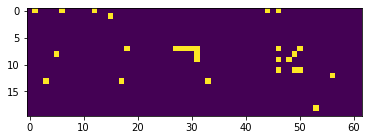


ExtractedWithXY_Cleaned185033_09102019.mat
[ 0  2  7 10 14 18 19 20 27 29 31 35 39 50]
Min: 1.00
Max: 1.00


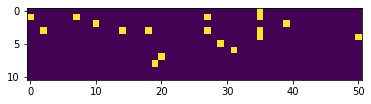


ExtractedWithXY_Cleaned184331_09102019.mat
[ 1  3  6 14]
Min: 1.00
Max: 1.00


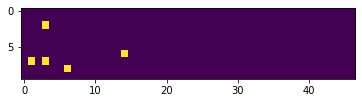


ExtractedWithXY_Cleaned144233_09112019.mat
[ 0  5  7  9 11 13 14 18 19 20 22 23 26 29 30 32 33 36 45 46 47 49 51]
Min: 1.00
Max: 1.00


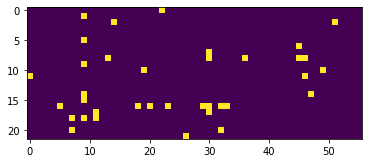


Total Num: 107


In [14]:
total = 0
for key1 in results.keys():
    cache_idx_mat = results[key1]
    cache_idx_mat = np.clip(cache_idx_mat, 0, 1)
    neurs = np.argwhere(np.sum(cache_idx_mat, axis=0)>0).squeeze()
    print(key1)
    print(neurs)
    print("Min: %1.2f"%cache_idx_mat[cache_idx_mat > 0].min())
    print("Max: %1.2f"%cache_idx_mat.max())
    plt.imshow(cache_idx_mat); plt.show()
    print()
    total += neurs.size
print("Total Num: %d"%total)

## Identifying specific episode cells visit-by-visit
Looking at a window around each cache. Specificity for a cache at a specific location

In [11]:
results = {}
for mat_file in mat_files:
    print(mat_file)
    f = h5py.File("data/" + mat_file, 'r')
    f = DataFile(f)
    cache_idxs = np.zeros((f.cache_sites.size, f.num_neurs))
    results[mat_file] = np.zeros((f.cache_sites.size, f.num_neurs))
    for idx in range(f.cache_sites.size):
        cache_site = f.cache_sites[idx]
        cache_frames = np.arange(f.cache_enters[idx], f.cache_exits[idx]).astype(int)
        noncache_enters = f.noncache_enters[f.noncache_wedges == cache_site]
        noncache_exits = f.noncache_exits[f.noncache_wedges == cache_site]
        noncache_frames = [
            np.arange(enter, exit).astype(int) for \
            enter, exit in zip(noncache_enters, noncache_exits)
            ]
        noncache_frames = np.concatenate(noncache_frames)
        context_frames = np.concatenate([
            cache_frames, noncache_frames
            ])
        contexts = np.concatenate([
            np.ones(cache_frames.size),
            np.zeros(noncache_frames.size)
            ])
        cache_info = get_mutual_info_mat(contexts, f.fr[context_frames,:])
        significant = np.zeros(f.num_neurs)
        shuffled_infos = np.zeros(f.num_neurs)
        for _ in range(110):
            shuff_spikes = f.spikes[context_frames,:]
            shuff_spikes = circular_shuffle(shuff_spikes)
            shuff_fr = get_fr(shuff_spikes)
            shuff_cache_info = get_mutual_info_mat(
                contexts, shuff_fr
                )
            shuffled_infos += shuff_cache_info
            significant += (cache_info > shuff_cache_info)
        significant = significant > 0.99*110
        shuffled_infos = shuffled_infos/110
        results[mat_file][idx, significant] = \
            cache_info[significant]#/shuffled_infos[significant]
# with open("mi-agglom-circshuff-%d.p"%window, "wb") as f:
#     pickle.dump(results, f)

ExtractedWithXY_Cleaned184713_09102019.mat
ExtractedWithXY_Cleaned184430_09102019.mat
ExtractedWithXY_Cleaned184526_09102019.mat
ExtractedWithXY_Cleaned184946_09102019.mat
ExtractedWithXY_Cleaned185033_09102019.mat
ExtractedWithXY_Cleaned184331_09102019.mat
ExtractedWithXY_Cleaned144233_09112019.mat


ExtractedWithXY_Cleaned184713_09102019.mat
[ 1  2  4  5  6  7  8 11 12 13 14 16 17 18 19 21 22 23 24 25 27 28 29 30
 31 32 33 34 36 37 38 39 40 41]
Min: 0.00
Max: 0.06


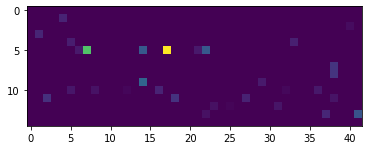


ExtractedWithXY_Cleaned184430_09102019.mat
[ 0  1  6  7  8  9 10 11 12 13 16 19 20 22 23 24 25 27 28 29 30 31 33 35
 36 37 38 39 40 41 44 45 47]
Min: 0.00
Max: 0.07


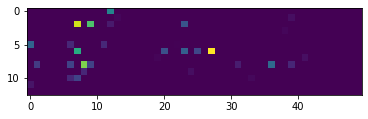


ExtractedWithXY_Cleaned184526_09102019.mat
[ 0  3  4  7  8 10 13 15 16 19 21 23 25 28 29 31 33 34 35 36 37 38 39 40
 41 42 43 44 47]
Min: 0.00
Max: 0.09


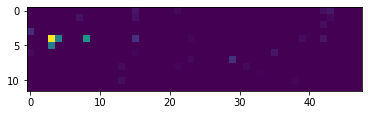


ExtractedWithXY_Cleaned184946_09102019.mat
[ 1  2  3  4  6  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 60 61]
Min: 0.00
Max: 0.06


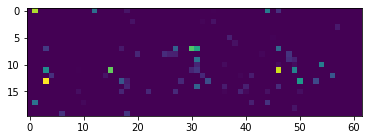


ExtractedWithXY_Cleaned185033_09102019.mat
[ 6  7  8  9 11 15 16 18 19 20 21 22 24 28 29 31 32 33 34 35 38 39 40 43
 44 45 46 49 50]
Min: 0.00
Max: 0.08


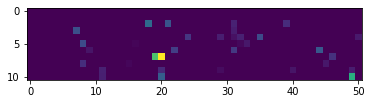


ExtractedWithXY_Cleaned184331_09102019.mat
[ 1  9 13 14 20 21 29 30 32 34 37 38 39 40 43 44 46]
Min: 0.00
Max: 0.02


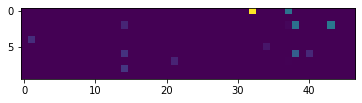


ExtractedWithXY_Cleaned144233_09112019.mat
[ 1  2  3  5  6  8  9 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27 29
 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 48 49 51 52 53 54]
Min: 0.00
Max: 0.03


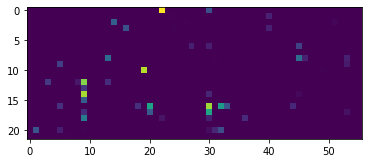


Total Num: 243


In [12]:
# with open("mi-agglom-shuff-30.p", "rb") as f:
#     results = pickle.load(f)
total = 0
for key1 in results.keys():
    cache_idx_mat = results[key1]
    neurs = np.argwhere(np.sum(cache_idx_mat, axis=0)>0).squeeze()
    print(key1)
    print(neurs)
    print("Min: %1.2f"%cache_idx_mat[cache_idx_mat > 0].min())
    print("Max: %1.2f"%cache_idx_mat.max())
    plt.imshow(cache_idx_mat); plt.show()
    print()
    total += neurs.size
print("Total Num: %d"%total)